# Optimization Methods for Data Science
### A.A. 2023-2024

Alessandro Pannone
Ph.D. Student @ Sapienza University of Rome

pannone@diag.uniroma1.it

## Optimization for Neural Networks

You have a dataset $ D = \{(x_i,y_i), x_i \in \mathbb{R}^2, y_i \in \mathbb{R}, i=1,\dots,P\}$. For every $i$, you know that $f(x_i) = y_i$ and you want to estimate $f(\cdot)$.

If your neural network approximates the function as $\tilde f (\omega;\cdot)$, where $\omega \in \mathbb{R}^n$ are your network weights, you have to solve:

$$ \min_{\omega \in \mathbb{R}^n} \sum_{i=1}^P (\tilde f (\omega;x_i) - y_i)^2 + \rho \vert \vert \omega \vert \vert
$$

Let's use a simple __MultiLayer Perceptron__ with 1 hidden layer, $N=5$ neurons and $n=2$ inputs.

The variables are:

$$ \omega = (W,b,v) \qquad W \in \mathbb{R}^{N \times n}, \ b \in \mathbb{R}^{N}, \ v\in\mathbb{R}^N
$$

where: 


*   $W$ is the matrix of weights for the hidden layer
*   $b$ is the vector of bias for neurons of the hidden layer
*   $v$ is the vector of weights for the output layer
 


In [ ]:
import numpy as np
from scipy.optimize import minimize
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
np.random.seed(12)

#### Function to estimate

In [ ]:
def f(x: np.ndarray) -> np.ndarray:
    x1 = x[0, :]
    x2 = x[1, :]
    return x1**2 + x2**2 + (x1**2)*(x2**2)

#### Build Dataset

In [ ]:
# POINTS OF THE DATASET
N_POINTS = 100

# DIMENSION OF X
INPUT_DIM = 2

X = np.random.uniform(low=-1, high=1, size=[INPUT_DIM, N_POINTS])
Y = f(x=X).reshape([1, N_POINTS])
Dataset = [X, Y]

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

Remember that a function, to be optimized, has to take all the variables inside one array.
However, it is convenient to ensemble again the variables in their original format.

To do this, let's define two utility functions

In [ ]:
from typing import Tuple

def unroll(W: np.ndarray, b: np.ndarray, v: np.ndarray) -> np.ndarray:
    """
    Flattens alle the neural network parameters inside a long vector --> Call this function when computing gradient!
    NOTE: In flattened_array elements are ordered in this way: W --> b --> v
    """

    W_flattened = np.ravel(W)
    b_flattened = np.ravel(b)
    v_flattened = np.ravel(v)

    return np.concatenate([W_flattened, b_flattened, v_flattened], axis=-1)

def roll(
    flattened_array: np.ndarray, 
    W_shape: np.ndarray, 
    b_shape: np.ndarray, 
    v_shape: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Reconstructs W, b and v original arrays
    NOTE: In flattened_array elements are ordered in this way: W --> b --> v

    Returns: (W, b, v)
    """

    # MULTIPLY W SHAPE --> IF W.SHAPE == (3, 4) --> W_ELEMENTS = 3 x 4 = 12
    w_elements = np.prod(W_shape)
    b_elements= np.prod(b_shape)
    v_shape = np.prod(v_shape)

    W = np.reshape(flattened_array[:w_elements], shape=W_shape)
    b = np.reshape(flattened_array[w_elements:w_elements+b_elements], shape=b_shape)
    v = np.reshape(flattened_array[w_elements+b_elements:], shape=v_shape)

    return W, b, v

In [ ]:
# EXAMPLES
W = np.arange(9).reshape([3, 3])
b = np.array([-1, -2, -3])
v = np.array([98, 99, 100])

print("W:")
print(W)
print()

print("b:")
print(b)
print()

print("v:")
print(v)
print()

W_shape = W.shape
b_shape = b.shape
v_shape = v.shape

# UNROLL
flattened_array = unroll(W, b, v)
print("Unrolled: ", flattened_array)

# ROLL
W_rolled, b_rolled, v_rolled = roll(flattened_array, W_shape, b_shape, v_shape)

print("W_rolled:")
print(W_rolled)
print()

print("b_rolled:")
print(b_rolled)
print()

print("v_rolled:")
print(v_rolled)
print()

#### Build Model

As Activation Function we will use the __hyperbolic tangent__

$$g(x) = \frac{e^{x}-e^{x}}{e^{x}+e^{-x}}$$

The derivative of the *tanh* function is:
$$\frac{\partial g(x)}{\partial x} = (1-g^2(x))$$

In [ ]:
def g(x: np.ndarray) -> np.ndarray:
    """
    Applies hyperbolic tangent element-wise
    """

    return np.tanh(x)

def dg_dx(x: np.ndarray) -> np.ndarray:
    """
    Returns the gradient of the hyperbolic tangent
    """

    return 1 - g(x)**2

In [ ]:
# RECAP OF DIMENSION FOR OUR MLP
HIDDEN_NEURONS = 10
INPUT_DIM = 2
OUTPUT_DIM = 1

# INITIALIZE MLP PARAMETERS
W = np.random.randn(HIDDEN_NEURONS, INPUT_DIM)
b = np.random.randn(HIDDEN_NEURONS, 1)
v = np.random.randn(OUTPUT_DIM, HIDDEN_NEURONS)

# GET SHAPES
W_shape = W.shape
b_shape = b.shape
v_shape = v.shape

# BUILD MODEL
def forward(X: np.ndarray, W: np.ndarray, b: np.ndarray, v: np.ndarray) -> np.ndarray:
    """
    Forward propagation
    """

    # A SHAPE: [HIDDEN_NEURONS, N_POINTS]
    a = np.dot(W, X) + b

    # Z SHAPE: [HIDDEN_NEURONS, N_POINTS]
    z = g(a)

    # OUT SHAPE: [OUTPUT_DIM, N_POINTS]
    out = np.dot(v, z)

    return out

#### Build Error Function
$$ E(W,b,v) = \frac{1}{2P} \sum_{i=1}^P (v^T g(Wx_i + b) - y_i)^2 + \frac{1}{2} \rho (\vert \vert W \vert \vert ^2+ \vert \vert v \vert \vert ^2)$$

In [ ]:
REGULARIZATION_TERM = 1e-4

def E(
        omega: np.ndarray,  # FIRST ARGUMENT!
        Dataset: Tuple[np.ndarray, np.ndarray], 
    ) -> np.ndarray:
    """
    Loss function to optimize

    Parameters:
    omega: unrolled parameters of MLP
    Dataset: [X, Y]
    reg_term: regularization term
    """

    X = Dataset[0]
    Y = Dataset[1]

    W, b, v = roll(omega, W_shape, b_shape, v_shape)

    out = forward(X, W, b, v)

    n_points = X.shape[1]
    error = 1 / (2 * n_points) * np.sum((out - Y)**2)
    regularization = 0.5 * REGULARIZATION_TERM * (np.sum(W**2) + np.sum(v**2))

    return error + regularization
    

## Training

Training the Neural Network we built means computing the value of the parameters $\omega=(W,b,v)$ based on data from the training set D.

This is done by minimizing the __empirical error__:

$$ E(W,b,v) = \frac{1}{2P} \sum_{i=1}^P (v^T g(Wx_i + b) - y_i)^2 + \frac{1}{2} \rho (\vert \vert W \vert \vert ^2+ \vert \vert v \vert \vert ^2)$$

Let's compute the gradient of the error function:

$$\frac{\partial E(W,b,v)}{\partial w_{hj}} = \frac{1}{P}\sum_{i=1}^P(v^Tg(Wx_i+b)-y_i)v_j(g'(W_jx_i+b_j))x_{ih} + \rho w_{hj}$$ 

$$\frac{\partial E(W,b,v)}{\partial b_j} = \frac{1}{P}\sum_{i=1}^P(v^Tg(Wx_i+b)-y_i)v_j(g'(W_jx_i+b_j))$$

$$\frac{\partial E(W,b,v)}{\partial v_j} = \frac{1}{P}\sum_{i=1}^P(v^Tg(Wx_i+b)-y_i)(g(W_jx_i+b_j)) + \rho v_j $$



In [ ]:
def dE_dOmega(omega: np.ndarray, Dataset: Tuple[np.ndarray, np.ndarray]) -> np.ndarray:
    """
    Computes the gradient of error funcion w.r.t all MLP parameters
    """

    # UNPACK DATASET
    X = Dataset[0]
    Y = Dataset[1]

    # UNPACK MLP PARAMETERS
    W, b, v = roll(omega, W_shape, b_shape, v_shape)

    # COMPUTE GRADIENTS
    grad_v = np.array([[dE_dv(W,b,v,X,Y,j)] for j in range(v.shape[0])])
    grad_b = np.array([[dE_db(W,b,v,X,Y,j)] for j in range(b.shape[0])])
    grad_W = np.array([[dE_dW(W,b,v,X,Y,h,j) for h in range(W.shape[1])] for j in range(W.shape[0])])

    #print(f"v shape: {v.shape} -- grad v shape: {grad_v.shape}")
    #print(f"b shape: {b.shape} -- grad b shape: {grad_b.shape}")
    #print(f"W shape: {W.shape} -- grad W shape: {grad_W.shape}") 

    # UNROLL GRADIENTS
    return unroll(grad_W, grad_b, grad_v)

def dE_dv(
    W: np.ndarray,
    b: np.ndarray,
    v: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
    j: np.ndarray,
) -> np.ndarray:
    """
    Computes the gradient of error function w.r.t. v^j
    """
    
    t1 = np.dot(v, g(np.dot(W, X) + b)) - Y
    t2 = g(np.dot(W[j, :], X) + b[j])
    t3 = REGULARIZATION_TERM * v[j]
    
    return (1/X.shape[1]) * np.sum(t1 * t2) + t3
    
def dE_db(
    W: np.ndarray,
    b: np.ndarray,
    v: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
    j: np.ndarray,
) -> np.ndarray:
    """
    Computes the gradient of error function w.r.t. b^j
    """

    t1 = np.dot(v, g(np.dot(W, X) + b)) - Y
    t2 = v[j] * dg_dx(np.dot(W[j,:], X) + b[j])

    return (1/X.shape[1]) * np.sum(t1 * t2)

def dE_dW(
    W: np.ndarray,
    b: np.ndarray,
    v: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
    h: np.ndarray,
    j: np.ndarray,
) -> np.ndarray:
    """
    Computes gradient of error function w.r.t. w^jh
    """

    t1 = np.dot(v, g(np.dot(W, X) + b)) - Y
    t2 = v[j] * dg_dx(np.dot(W[j,:], X) + b[j])
    t3 = X[h,:]
    t4 = REGULARIZATION_TERM * W[j, h]

    return (1/X.shape[1]) * np.sum(t1 * t2 * t3) + t4


Let's check if the gradient we computed was correct by the finite-differences approximation.

__Forward differences__:
$$f'(x) \approx \frac{f(x+\Delta x)-f(x)}{\Delta x}$$

__Backward differences__:
$$f'(x) \approx \frac{f(x)-f(x-\Delta x)}{\Delta x}$$

__Central differences__:
$$f'(x) \approx \frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x}$$

Since the Central differences approximation is more stable, it is preferable to use this method.

In [ ]:
def central_differences(omega,Dataset):
  eps = 1.e-6
  gradient = dE_dOmega(omega,Dataset)
  approx_gradient = np.zeros(gradient.shape)
  for i in range(len(omega)):
    delta_omega = np.zeros(omega.shape)
    delta_omega[i] = eps
    approx_gradient[i] = (E(omega+delta_omega,Dataset)-E(omega-delta_omega,Dataset))/(2*eps)
    if np.abs(gradient[i]-approx_gradient[i])>1.e-2:
      print(f'Error in the {i}-th component of the gradient')
  if np.linalg.norm(gradient-approx_gradient)>1.e-4:
    print('Error in the gradient')
  else:
    print('Gradient ok')

omega0 = unroll(W, b, v)
central_differences(omega0,Dataset)


In [ ]:
def callback_function(x):
    """
    Add this function to scipy callbacks to print the loss every 10 iterations
    """

    if callback_function.iteration % 10 == 0:
        print("Function value at iteration {}: {}".format(callback_function.iteration, E(x, Dataset)))
    callback_function.iteration += 1

callback_function.iteration = 0


omega0 = unroll(W, b, v)

res = minimize(
    fun=E,
    x0=omega0,
    args=Dataset,
    method='BFGS',
    jac=dE_dOmega,
    tol=1e-8,
    callback=callback_function
)

In [ ]:
print("Parameters:")
W_star, b_star, v_star = roll(res.x, W_shape, b_shape, v_shape)
print("W:")
print(W_star)

print("b:")
print(b_star)

print("v:")
print(v_star)

print("Gradient Norm")
print(np.linalg.norm(res.jac))

## Test Model

In [ ]:
# GENERATE NEW DATA
X_test = np.random.uniform(low=-1, high=1, size=[INPUT_DIM, 20])
Y_test = f(x=X_test).reshape([1, 20])
Dataset_test = [X_test, Y_test]

# COMPARE RESULTS
prediction = forward(X_test, W_star, b_star, v_star)
print(np.mean(np.abs(((prediction - Y_test) / Y_test))))

## Try It by Yourself

#### Stochastic Gradient Descent
In this lecture we have used an optimizer already implemented in scipy.

Implement stochastic gradient descent!

#### Vectorize backpropagation
The function __dE_dOmega__ computes the gradient of the error function w.r.t. neural network parameters at this point:


__grad_v = np.array([[dE_dv(W,b,v,X,Y,j)] for j in range(v.shape[0])])__

__grad_b = np.array([[dE_db(W,b,v,X,Y,j)] for j in range(b.shape[0])])__

__grad_W = np.array([[dE_dW(W,b,v,X,Y,h,j) for h in range(W.shape[1])] for j in range(W.shape[0])])__



Implement all three method without using python "for loops". Use only numpy.

Why?
1) This is a more efficient solution
2) This will help you to familiarize with numpy operations
3) More points in the final project!

# BINARY CLASSIFICATION

Let's import a binary classification dataset.

### 🧬 Breast Cancer Dataset (sklearn)

The Breast Cancer Wisconsin dataset is a commonly used dataset for binary classification. It contains **569 samples** with **30 numerical features**, describing characteristics of cell nuclei in digitized images of breast mass biopsies.

- **Target variable**:  
  - `0` = malignant  
  - `1` = benign  
- **Source**: UCI Machine Learning Repository



In [22]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *

In [24]:
data = load_breast_cancer()
X = data['data']
Y = data['target']

print(f'Num samples {X.shape[0]}, num features {X.shape[1]}, num classes {len(np.unique(Y))}')
print(f'Balancing {np.unique(Y,return_counts=True)[1]/X.shape[0]}')

df = pd.DataFrame(X)
df.describe()

Num samples 569, num features 30, num classes 2
Balancing [0.37258348 0.62741652]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [26]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123, stratify=Y)

print(f'Number of samples in the training set {X_tr.shape[0]}')
print(f'Number of samples in the test set {X_ts.shape[0]}')

print(f'Balancing train {np.unique(Y_tr,return_counts=True)[1]/X_tr.shape[0]}')
print(f'Balancing test {np.unique(Y_ts,return_counts=True)[1]/X_ts.shape[0]}')

Number of samples in the training set 455
Number of samples in the test set 114
Balancing train [0.37362637 0.62637363]
Balancing test [0.36842105 0.63157895]


### Data Standardization
As a good practice, we __always__ have to scale/normalize data before applying any algorithm. It is mandatory when data varies on different scales but it is always a wise choice. The main reason is that usually algorithms are not _scale-invariant_ and so features with different scales have different effects on the updating rule (e.g. thinks about gradient descent update)!<br>


Let's remember how to scale/standardize data:

For each feature $x_i$
$$Standardization: \frac{x_i-\mu_i}{\sigma_i} \qquad Scaling: \frac{x_i-m_i}{M_i-m_i}$$
where:
$$M_i=max(x_i) \qquad m_i=Min(x_i)$$


To scale/standardize data we can rely on the packages [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) or [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of Sklearn.<br>

__Important issue:__ when scaling/standardizing data we need to fit the values ($\mu_i,\sigma_i\dots$) on the training set and then applying the same transformation on the test set for two main reasons:
- we don't have the test set during the training phase, so we cannot evaluate $\mu_i,\sigma_i\dots$ with the test data
- computing $\mu_i,\sigma_i...$ using also the test set would be like insert information of the test set on the training set. __It's like cheating!__

In [27]:
scaler = StandardScaler()

X_tr = scaler.fit_transform(X_tr)
X_ts = scaler.transform(X_ts)

Be careful with the difference between fit_transform and trasform:
- fit_transform computes $\mu$s and $\sigma$s and applies the transformation to the train set
- transform standardize the data using the $\mu$s and $\sigma$s computed on the training set by the function fit_transform

In [28]:
def train_evaluate(model, X_tr, Y_tr, X_ts, Y_ts):
  model.fit(X_tr, Y_tr)

  print(f'Train accuracy {accuracy_score(Y_tr, model.predict(X_tr))}, precision {precision_score(Y_tr, model.predict(X_tr))}, recall {recall_score(Y_tr, model.predict(X_tr))}')
  print(f'Test accuracy {accuracy_score(Y_ts, model.predict(X_ts))}, precision {precision_score(Y_ts, model.predict(X_ts))}, recall {recall_score(Y_ts, model.predict(X_ts))}')
  return model

model = MLPClassifier(
  hidden_layer_sizes=[5, 5],
  activation='tanh',
  solver='lbfgs',
  max_iter=1000,
)

train_evaluate(model, X_tr, Y_tr, X_ts, Y_ts)

Train accuracy 1.0, precision 1.0, recall 1.0
Test accuracy 0.9298245614035088, precision 0.9444444444444444, recall 0.9444444444444444


MLPClassifier(activation='tanh', hidden_layer_sizes=[5, 5], max_iter=1000,
              solver='lbfgs')

# K-Fold Cross validation
To train Machine Learning models, we have to choose their hyperparameters. For Support Vector Machine, for example, the hyperparameters are C and the hyperparameters of the kernel function, if any.

The standard option for choosing the best value for the hyperparameters is to implement a $k$-fold crossvalidation:
* We choose, for each hyperparameter, a list of values we want to try;
* The term grid search refers to the process in which we analyze each possible combination of values of all hyperparameters and choose the best one;
* Each combination is tested by using a $k$-fold crossvalidation;
* The combination associated with the higher crossvalidation score is returned in output.

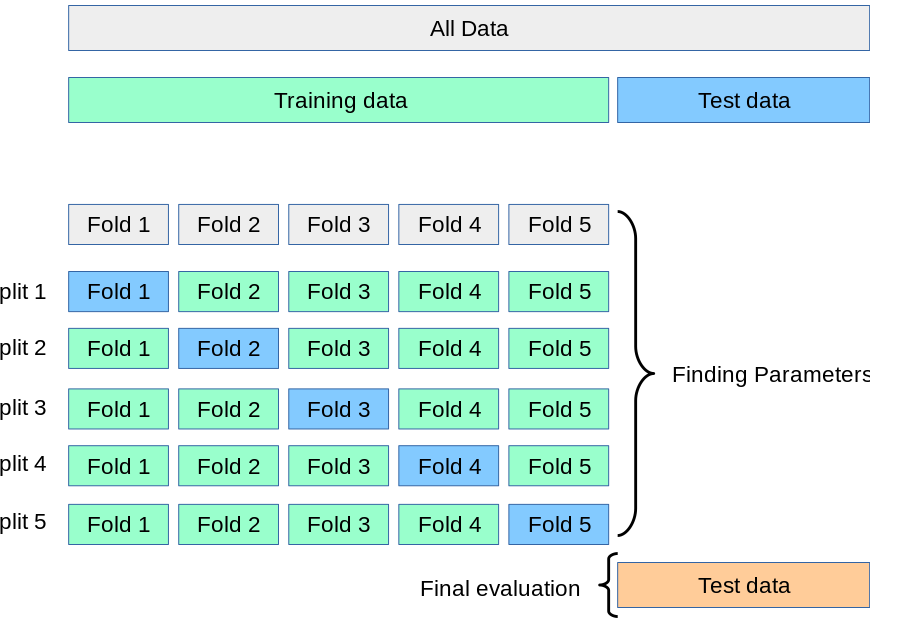

In [29]:
model = GridSearchCV(
    estimator=MLPClassifier(solver='lbfgs', max_iter=200), 
    param_grid={
        'hidden_layer_sizes': [(5, 5), (10, 10), (20, 20)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001],
    },
    cv=5,
    scoring='accuracy'
)
model = train_evaluate(model, X_tr, Y_tr, X_ts, Y_ts)
print()

# Best model
print(f"best estimator: {model.best_estimator_}")
print()

# Best parameters
print(f"best hyperparameters: {model.best_params_}")
print()

# Useful info
#pprint(object=model.cv_results_)
config=model.cv_results_["params"]
print(f"config: {config}")
print()

val_scores = model.cv_results_["mean_test_score"]
print(f"val scores: {val_scores}")


Train accuracy 1.0, precision 1.0, recall 1.0
Test accuracy 0.956140350877193, precision 0.958904109589041, recall 0.9722222222222222

best estimator: MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5), solver='lbfgs')

best hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5)}

config: [{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5)}, {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10)}, {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20)}, {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (5, 5)}, {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10, 10)}, {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (20, 20)}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 5)}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10)}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20)}, {'activation': 'relu',